In [1]:
from ipywidgets import *
from PIL import Image
from datetime import datetime

import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

import io

In [2]:
def resize(image):
    return cv.resize(image, OUTPUT_SIZE)

In [3]:
def get_ROI(msk_prediction):
    img = cv.cvtColor(msk_prediction.astype(np.uint8),cv.COLOR_BGR2GRAY) #converting to grayscale
    img = img.astype(np.int32)

    coord = cv.findNonZero(img)

    #x max, y min
    x_max = max(coord, key=lambda x: (x[0][0]))[0][0]
    y_min = max(coord, key=lambda x: (-x[0][1]))[0][1]
    start_point = [x_max, y_min]

    #x min, y max
    x_min = max(coord, key=lambda x: (-x[0][0]))[0][0]
    y_max = max(coord, key=lambda x: (x[0][1]))[0][1]
    end_point =  [x_min, y_max]
    return start_point, end_point



In [4]:
def make_prediction(model, image):
    image = resize(image)
    pred = model(np.array([image]))
    
    startTime = datetime.now()
    pred = np.argmax (pred, axis=-1) [0, :,:]
    time = (datetime.now() - startTime).total_seconds() * 1000
    return pred, image, time

In [5]:
def on_click(change):
    image = np.array(Image.open(io.BytesIO(btn_upload.data[-1]))) 
    unet = tf.keras.models.load_model('./saved_models/burger_menu_finder(0.89).h5', compile=False)
    prediction, image, time = make_prediction(unet, image)
    
    start_point, end_point = get_ROI(colors[prediction])
    x_clone = image.copy()
    ROI_image = cv.rectangle(x_clone, start_point, end_point, (255, 0, 0), 3)
    
    out_pl.clear_output()
    plt.figure(figsize = (15,15))
    plt.axis('off') 
    plt.title("Model Prediction")
    with out_pl: display(plt.imshow(ROI_image))
        
    lbl_pred.value = 'Speed: %s ms' % time

In [6]:
first_d = 64*5
second_d = 64*12
OUTPUT_SIZE = (first_d, second_d)
colors = np.array([(0, 0, 0),
                   (157, 234, 50)])

btn_upload = widgets.FileUpload(accept='.png', multiple=False)
btn_run = widgets.Button(description='Find!')
btn_run.on_click(on_click)
out_pl = widgets.Output()
lbl_pred = widgets.Label()

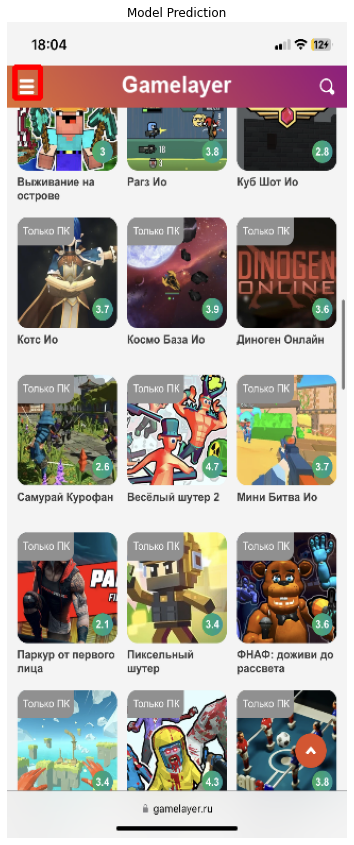

In [7]:
VBox([widgets.Label("Let's find a Burger Menu!"), 
      btn_upload, btn_run, out_pl, lbl_pred])